# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2017-07-25 17:31:10,628] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [6]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

         
        # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [8]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [9]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [10]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [12]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    #env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [13]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 7.0 Training loss: 1.2259 Explore P: 0.9993
Episode: 2 Total reward: 38.0 Training loss: 1.2061 Explore P: 0.9956
Episode: 3 Total reward: 11.0 Training loss: 1.2143 Explore P: 0.9945
Episode: 4 Total reward: 13.0 Training loss: 1.3947 Explore P: 0.9932
Episode: 5 Total reward: 43.0 Training loss: 0.9891 Explore P: 0.9890
Episode: 6 Total reward: 8.0 Training loss: 1.0778 Explore P: 0.9882
Episode: 7 Total reward: 14.0 Training loss: 1.1377 Explore P: 0.9868
Episode: 8 Total reward: 35.0 Training loss: 0.9498 Explore P: 0.9834
Episode: 9 Total reward: 30.0 Training loss: 1.2475 Explore P: 0.9805
Episode: 10 Total reward: 17.0 Training loss: 1.3953 Explore P: 0.9788
Episode: 11 Total reward: 10.0 Training loss: 1.3703 Explore P: 0.9779
Episode: 12 Total reward: 37.0 Training loss: 1.2207 Explore P: 0.9743
Episode: 13 Total reward: 21.0 Training loss: 1.4511 Explore P: 0.9723
Episode: 14 Total reward: 11.0 Training loss: 1.4797 Explore P: 0.9712
Episode: 15 Total

Episode: 116 Total reward: 17.0 Training loss: 5.5211 Explore P: 0.7998
Episode: 117 Total reward: 11.0 Training loss: 5.4256 Explore P: 0.7990
Episode: 118 Total reward: 22.0 Training loss: 71.0140 Explore P: 0.7972
Episode: 119 Total reward: 19.0 Training loss: 103.0879 Explore P: 0.7957
Episode: 120 Total reward: 18.0 Training loss: 4.9994 Explore P: 0.7943
Episode: 121 Total reward: 17.0 Training loss: 108.0990 Explore P: 0.7930
Episode: 122 Total reward: 10.0 Training loss: 83.9440 Explore P: 0.7922
Episode: 123 Total reward: 12.0 Training loss: 5.1475 Explore P: 0.7913
Episode: 124 Total reward: 15.0 Training loss: 4.8145 Explore P: 0.7901
Episode: 125 Total reward: 8.0 Training loss: 4.1791 Explore P: 0.7895
Episode: 126 Total reward: 27.0 Training loss: 69.2542 Explore P: 0.7874
Episode: 127 Total reward: 33.0 Training loss: 50.9837 Explore P: 0.7848
Episode: 128 Total reward: 19.0 Training loss: 80.3863 Explore P: 0.7833
Episode: 129 Total reward: 17.0 Training loss: 118.0272 

Episode: 230 Total reward: 29.0 Training loss: 58.9717 Explore P: 0.6528
Episode: 231 Total reward: 23.0 Training loss: 24.1339 Explore P: 0.6514
Episode: 232 Total reward: 13.0 Training loss: 1.1186 Explore P: 0.6505
Episode: 233 Total reward: 8.0 Training loss: 51.6359 Explore P: 0.6500
Episode: 234 Total reward: 17.0 Training loss: 1.6592 Explore P: 0.6489
Episode: 235 Total reward: 14.0 Training loss: 44.5170 Explore P: 0.6480
Episode: 236 Total reward: 11.0 Training loss: 46.9945 Explore P: 0.6473
Episode: 237 Total reward: 20.0 Training loss: 23.4574 Explore P: 0.6461
Episode: 238 Total reward: 13.0 Training loss: 22.8689 Explore P: 0.6452
Episode: 239 Total reward: 25.0 Training loss: 1.2260 Explore P: 0.6437
Episode: 240 Total reward: 16.0 Training loss: 1.6243 Explore P: 0.6426
Episode: 241 Total reward: 39.0 Training loss: 32.1593 Explore P: 0.6402
Episode: 242 Total reward: 13.0 Training loss: 0.9532 Explore P: 0.6394
Episode: 243 Total reward: 9.0 Training loss: 11.0273 Exp

Episode: 344 Total reward: 91.0 Training loss: 80.0923 Explore P: 0.3740
Episode: 345 Total reward: 108.0 Training loss: 1.9513 Explore P: 0.3701
Episode: 346 Total reward: 65.0 Training loss: 1.4700 Explore P: 0.3677
Episode: 347 Total reward: 188.0 Training loss: 4.5159 Explore P: 0.3611
Episode: 348 Total reward: 42.0 Training loss: 1.9070 Explore P: 0.3596
Episode: 349 Total reward: 36.0 Training loss: 37.6044 Explore P: 0.3583
Episode: 350 Total reward: 69.0 Training loss: 1.7312 Explore P: 0.3560
Episode: 351 Total reward: 124.0 Training loss: 14.0449 Explore P: 0.3517
Episode: 352 Total reward: 73.0 Training loss: 3.1433 Explore P: 0.3492
Episode: 353 Total reward: 39.0 Training loss: 59.6304 Explore P: 0.3479
Episode: 354 Total reward: 70.0 Training loss: 36.3910 Explore P: 0.3455
Episode: 355 Total reward: 29.0 Training loss: 2.0024 Explore P: 0.3446
Episode: 356 Total reward: 56.0 Training loss: 3.1188 Explore P: 0.3427
Episode: 357 Total reward: 87.0 Training loss: 107.7496 

Episode: 457 Total reward: 55.0 Training loss: 0.5253 Explore P: 0.1642
Episode: 458 Total reward: 59.0 Training loss: 0.4229 Explore P: 0.1633
Episode: 459 Total reward: 56.0 Training loss: 0.5330 Explore P: 0.1625
Episode: 460 Total reward: 68.0 Training loss: 0.4868 Explore P: 0.1614
Episode: 461 Total reward: 59.0 Training loss: 0.2312 Explore P: 0.1605
Episode: 462 Total reward: 55.0 Training loss: 0.4228 Explore P: 0.1597
Episode: 463 Total reward: 54.0 Training loss: 0.9403 Explore P: 0.1589
Episode: 464 Total reward: 56.0 Training loss: 0.5026 Explore P: 0.1581
Episode: 465 Total reward: 57.0 Training loss: 0.5627 Explore P: 0.1572
Episode: 466 Total reward: 66.0 Training loss: 5.0979 Explore P: 0.1563
Episode: 467 Total reward: 118.0 Training loss: 6.5184 Explore P: 0.1545
Episode: 468 Total reward: 113.0 Training loss: 0.3858 Explore P: 0.1529
Episode: 469 Total reward: 100.0 Training loss: 0.2893 Explore P: 0.1515
Episode: 470 Total reward: 92.0 Training loss: 7.7815 Explore

Episode: 570 Total reward: 199.0 Training loss: 0.2410 Explore P: 0.0447
Episode: 571 Total reward: 199.0 Training loss: 257.9892 Explore P: 0.0440
Episode: 572 Total reward: 151.0 Training loss: 241.3951 Explore P: 0.0435
Episode: 573 Total reward: 199.0 Training loss: 0.2932 Explore P: 0.0428
Episode: 574 Total reward: 104.0 Training loss: 0.3017 Explore P: 0.0425
Episode: 575 Total reward: 199.0 Training loss: 0.1433 Explore P: 0.0419
Episode: 576 Total reward: 199.0 Training loss: 0.1891 Explore P: 0.0412
Episode: 577 Total reward: 199.0 Training loss: 148.0824 Explore P: 0.0406
Episode: 578 Total reward: 199.0 Training loss: 0.2337 Explore P: 0.0400
Episode: 579 Total reward: 199.0 Training loss: 0.0928 Explore P: 0.0394
Episode: 580 Total reward: 166.0 Training loss: 0.2071 Explore P: 0.0389
Episode: 581 Total reward: 144.0 Training loss: 0.2317 Explore P: 0.0385
Episode: 582 Total reward: 199.0 Training loss: 0.2813 Explore P: 0.0380
Episode: 583 Total reward: 96.0 Training loss

Episode: 683 Total reward: 192.0 Training loss: 0.3682 Explore P: 0.0163
Episode: 684 Total reward: 173.0 Training loss: 0.3634 Explore P: 0.0161
Episode: 685 Total reward: 199.0 Training loss: 0.1750 Explore P: 0.0160
Episode: 686 Total reward: 199.0 Training loss: 0.3028 Explore P: 0.0159
Episode: 687 Total reward: 169.0 Training loss: 0.2177 Explore P: 0.0158
Episode: 688 Total reward: 101.0 Training loss: 0.2075 Explore P: 0.0157
Episode: 689 Total reward: 199.0 Training loss: 0.2162 Explore P: 0.0156
Episode: 690 Total reward: 199.0 Training loss: 0.2823 Explore P: 0.0155
Episode: 691 Total reward: 199.0 Training loss: 0.1273 Explore P: 0.0154
Episode: 692 Total reward: 199.0 Training loss: 0.1905 Explore P: 0.0153
Episode: 693 Total reward: 199.0 Training loss: 0.1241 Explore P: 0.0152
Episode: 694 Total reward: 194.0 Training loss: 0.0909 Explore P: 0.0151
Episode: 695 Total reward: 106.0 Training loss: 0.1418 Explore P: 0.0151
Episode: 696 Total reward: 199.0 Training loss: 0.1

Episode: 796 Total reward: 199.0 Training loss: 0.1955 Explore P: 0.0109
Episode: 797 Total reward: 199.0 Training loss: 0.1980 Explore P: 0.0108
Episode: 798 Total reward: 199.0 Training loss: 0.1709 Explore P: 0.0108
Episode: 799 Total reward: 199.0 Training loss: 0.1250 Explore P: 0.0108
Episode: 800 Total reward: 92.0 Training loss: 0.2093 Explore P: 0.0108
Episode: 801 Total reward: 199.0 Training loss: 0.1998 Explore P: 0.0108
Episode: 802 Total reward: 162.0 Training loss: 0.2466 Explore P: 0.0108
Episode: 803 Total reward: 190.0 Training loss: 0.2749 Explore P: 0.0108
Episode: 804 Total reward: 171.0 Training loss: 0.1216 Explore P: 0.0107
Episode: 805 Total reward: 199.0 Training loss: 0.3792 Explore P: 0.0107
Episode: 806 Total reward: 199.0 Training loss: 173.3123 Explore P: 0.0107
Episode: 807 Total reward: 141.0 Training loss: 0.3925 Explore P: 0.0107
Episode: 808 Total reward: 109.0 Training loss: 0.1257 Explore P: 0.0107
Episode: 809 Total reward: 199.0 Training loss: 0.

Episode: 908 Total reward: 199.0 Training loss: 0.2961 Explore P: 0.0101
Episode: 909 Total reward: 199.0 Training loss: 0.3408 Explore P: 0.0101
Episode: 910 Total reward: 199.0 Training loss: 0.2803 Explore P: 0.0101
Episode: 911 Total reward: 199.0 Training loss: 0.2816 Explore P: 0.0101
Episode: 912 Total reward: 199.0 Training loss: 0.2426 Explore P: 0.0101
Episode: 913 Total reward: 199.0 Training loss: 0.3191 Explore P: 0.0101
Episode: 914 Total reward: 199.0 Training loss: 0.2995 Explore P: 0.0101
Episode: 915 Total reward: 199.0 Training loss: 0.3368 Explore P: 0.0101
Episode: 916 Total reward: 199.0 Training loss: 0.2987 Explore P: 0.0101
Episode: 917 Total reward: 199.0 Training loss: 0.1652 Explore P: 0.0101
Episode: 918 Total reward: 199.0 Training loss: 0.1311 Explore P: 0.0101
Episode: 919 Total reward: 199.0 Training loss: 0.3301 Explore P: 0.0101
Episode: 920 Total reward: 199.0 Training loss: 0.2270 Explore P: 0.0101
Episode: 921 Total reward: 199.0 Training loss: 0.3

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

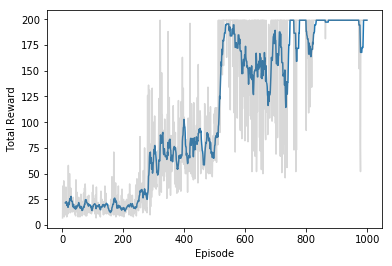

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [17]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


[2017-07-25 18:26:37,655] Restoring parameters from checkpoints/cartpole.ckpt


In [18]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.